In [1]:
import numpy as np
import operator
import logging
import time

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter, sigmasq, get_cutoff_indices

In [2]:
# Define the conditiion data function
dynfac = 1.0e23
def condition(strain, sampling_rate):
    tmp = resample_to_delta_t(highpass(strain, 15.0), 1.0/sampling_rate).crop(2,2)
    return (dynfac*tmp)

# Define the PSD function 
def estimate_psd(strain, delta_f):
    psd = strain.psd(4)
    psd = interpolate(psd, delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate),
                                  low_frequency_cutoff=15, trunc_method='hann')
    return psd

In [3]:
# Get the data and estimate the PSDs
merger = Merger("GW150914")
sampling_rate = 2048 # Sampling rate in Hz
data = condition(merger.strain('H1'), sampling_rate)
signal_duration = float(data.duration)  # Duration of the signal in seconds
delta_freq = data.delta_f
print(delta_freq)
invpsd = estimate_psd(data, data.delta_f)**(-1)

fcore = data.to_frequencyseries()*invpsd #this is what goes to multiply with template^*

#Get the frequency range
nyquist = sampling_rate//2
freqs = jnp.arange(1+(nyquist*signal_duration))/signal_duration

#freqs = jnp.arange(int(len(fcore)-1) * 2)???

#Determine the low freq and high frequency cut off
kmin, kmax = int(15*signal_duration), int(900*signal_duration)
print(kmin, kmax)
N = int(len(data)-1) * 2 
kmin, kmax = get_cutoff_indices(flow=15, fhigh=900, df=data.delta_f, N=N) # WHY DID you avoid using this?
print(kmin, kmax)

#Make everything the same length
fcore = jnp.asarray(fcore[kmin:kmax])
freqs = freqs[kmin:kmax]
invpsd = jnp.asarray(invpsd[kmin:kmax]) 
print(invpsd)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


0.03571428571428571
420 25200
420 25200
[7.38585049e-06 9.89650653e-06 1.28048205e-05 ... 5.74207425e-01
 5.45229197e-01 5.16039252e-01]


In [4]:
'''SNR'''
m1 = 30
m2 = 30

'''PSD'''
psd = estimate_psd(data, data.delta_f)

'''Template'''
pycbc_template, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=m1, mass2=m2, delta_f=delta_freq, f_lower=15)
print(f'Pycbc template = {pycbc_template}')

'''Sigma_squared'''
sq = sigmasq(pycbc_template, psd = psd, low_frequency_cutoff=15, high_frequency_cutoff=900)
print(sq)
print(f'Pycbc using the sigmasq function = {sq*dynfac**2}')
print({1/np.sqrt(sq*dynfac**2)})

'''Normalisation'''
my_norm = 4*delta_freq / jnp.sqrt(sq) 
print(f'The normalisation is {my_norm}')

'''Matched-filter Core'''
pycbc_template = jnp.asarray(pycbc_template[kmin:kmax], dtype=complex)
workspace = jnp.zeros(int(sampling_rate*signal_duration), dtype=complex) 
result_fft = fcore * jnp.conjugate(pycbc_template)
workspace = workspace.at[kmin:kmax].set(result_fft)
result = jnp.fft.ifft(workspace)
result *= len(result)
print(len(result))
'''SNR'''
snr = result*my_norm #a^2 + b^2 may have to be the real of snr^2 which si complex conjuate multipled itself 
snr_min = int((2+4)*sampling_rate)
snr_max = len(snr)-int((2)*sampling_rate)
snr = snr[snr_min:snr_max]
peak = jnp.argmax(jnp.absolute(snr))
snrp = jnp.absolute(snr[peak])
print(f'The value at the highest peak {snrp}')

Pycbc template = [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
1.958573667907937e-38
Pycbc using the sigmasq function = 195857366.79079366
{7.145457563853388e-05}
The normalisation is 1.0207797232795648e+18
57344
The value at the highest peak 16.026155471801758


/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/jax/_src/array.py:387: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


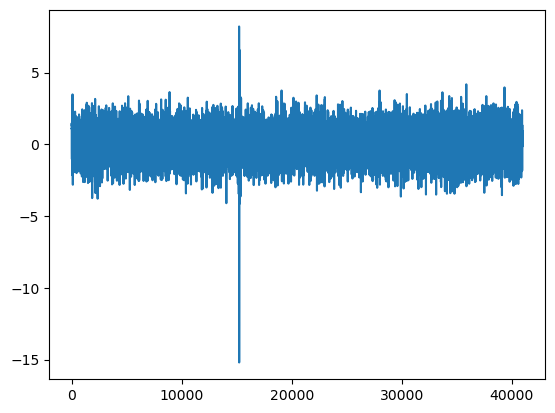

In [5]:
plt.plot(snr)

In [6]:
pycbc_template, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=m1, mass2=m2, delta_f=delta_freq, f_lower=15)
pycbc_template.resize(len(psd))
psd = estimate_psd(data, data.delta_f)
pycbc_snr = matched_filter(pycbc_template, data, psd=psd, low_frequency_cutoff=15)
pycbc_snr = pycbc_snr.crop(2 + 4, 2)
peak = abs(pycbc_snr).numpy().argmax()
pycbc_snrp = abs(pycbc_snr[peak])
print(pycbc_snrp)

16.026156288265174


/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


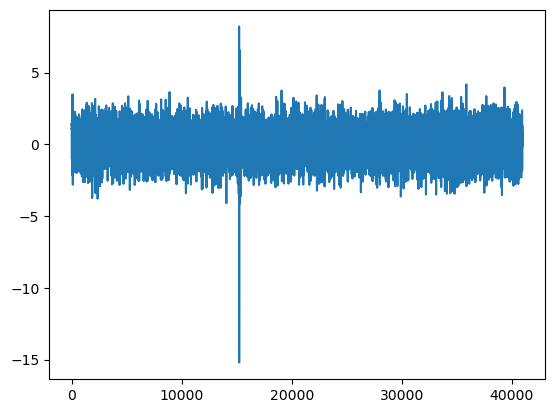

In [7]:
plt.plot(pycbc_snr)

In [8]:
snr.dtype

dtype('complex64')

(15200.0, 15300.0)

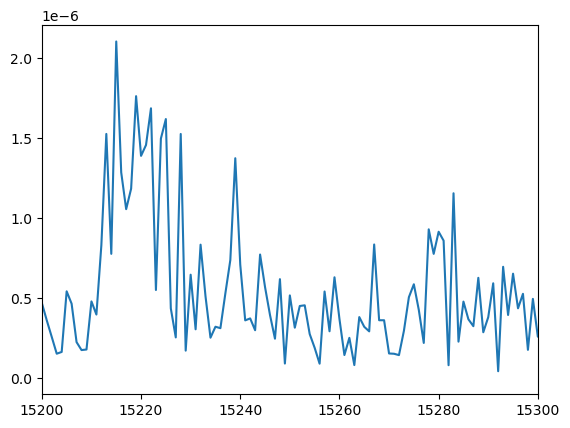

In [9]:
#plt.plot(abs(pycbc_snr))
#plt.plot(np.array(snr))
plt.plot(abs(pycbc_snr-np.array(snr)))
plt.xlim(15200,15300)

In [10]:
'''Sigma_squared'''
pycbc_template, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=m1, mass2=m2, delta_f=delta_freq, f_lower=15, f_final=900)
pycbc_template.resize(len(psd))
sq = sigmasq(pycbc_template, psd = psd, low_frequency_cutoff=15, high_frequency_cutoff=900)
print(sq)
print(f'Pycbc using the sigmasq function = {sq*dynfac**2}')
print({1/np.sqrt(sq*dynfac**2)})

pycbc_template = jnp.asarray(pycbc_template[kmin:kmax])
weighted_inner = jnp.sum(pycbc_template*jnp.conj(pycbc_template)*invpsd)
h_norm = 4*delta_freq
sigma_squared = jnp.real(weighted_inner)*h_norm
print(sigma_squared)
print(f'Sigma_squared using my code and a pycbc template = {sigma_squared*dynfac**2}')

1.9585736679079364e-38
Pycbc using the sigmasq function = 195857366.79079363
{7.145457563853388e-05}
0.0
Sigma_squared using my code and a pycbc template = nan
